## Problem 2

In [128]:
import math
import matplotlib.pyplot as plt
import numpy
import random
from scipy.optimize import curve_fit
import time

### (a)

In [129]:
dims = 3

def norm(vec):
    ret = 0
    for coord in vec:
        ret += (coord ** 2)
    return math.sqrt(ret)

def compute_energy(r_atoms):
    '''
    r_atoms: list of the location of atoms
    '''
    D = 1
    r_e = 1
    a = 1
    
    energy = 0
    num_atoms = len(r_atoms)
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            vec = [r_atoms[i][k] - r_atoms[j][k] for k in range(dims)]
            r = norm(vec)
            energy += D * ((1 - math.exp(-a * (r - r_e))) ** 2)
    return energy

In [130]:
# Testing compute_energy
r_atoms = [
    [0, 0, 0],
    [1, .5, 0],
    [.5, 1, 1]
]
print(compute_energy(r_atoms))

0.20772706611462197


### (b)

In [131]:
def center_of_mass(r_atoms):
    num_atoms = len(r_atoms)
    center_mass = [0 for _ in range(dims)]
    for r in r_atoms:
        for j in range(dims):
            center_mass[j] += r[j]
    center_mass = list(map(lambda x: x / num_atoms, center_mass))
    return center_mass

def metropolis_sampling(r_atoms, kT, num_iter):
    '''
    r_atoms --- intial position of atoms, passed in as a list of coordinates, arbitrarily number of atoms allowed
    kT --- temperature
    num_iter --- number of iterations to run
    '''
    start = time.time()
    num_atoms = len(r_atoms)
    sigma = 1
    sigma_accept_multiplier = 1.01
    sigma_reject_multiplier = 0.99
    beta = 1 / kT
    energy = compute_energy(r_atoms)
    num_accept = 0

    r_list = [None] * num_iter
    energy_list = [None] * num_iter
    cm_list = [None] * num_iter
    accept_list = [None] * num_iter

    for i in range(num_iter):
        # Propose a new position for each atom
        new_r_atoms = []
        for r in r_atoms:
            z = [numpy.random.normal(0, 1), numpy.random.normal(0, 1), numpy.random.normal(0, 1)]
            # Scale by sigma
            z = list(map(lambda x: x * sigma, z))
            new_r = [r[j] - z[j] for j in range(dims)]
            new_r_atoms.append(new_r)
        # Calculate acceptance probability
        new_energy = compute_energy(new_r_atoms)
        # Metropolis
        A = min(1, math.exp(- beta * (new_energy - energy)))
        # Accept
        if A > random.uniform(0, 1):
            num_accept += 1
            # We want to keep accepting higher sigma
            sigma *= sigma_accept_multiplier
            accept_list[i] = True
            # Update position and energy
            r_atoms = new_r_atoms
            energy = new_energy
            # Recenter center of mass to origin
            center_mass = center_of_mass(r_atoms)
            for atom_num in range(num_atoms):
                r_atoms[atom_num] = [r_atoms[atom_num][j] - center_mass[j] for j in range(3)]
        # Reject
        else:
            sigma *= sigma_reject_multiplier
            accept_list[i] = False

        r_list[i] = r_atoms
        energy_list[i] = energy
        cm_list[i] = center_of_mass(r_atoms)

    print(f"Finished running simulation with kT = {kT}, # iterations = {num_iter}")
    print(f"Simulation time: {round(time.time() - start, 3)}s")
    print(f"Accept ratio: {round(num_accept / num_iter, 4)}")
    return r_list, energy_list


### (c)

In [132]:
def autocorrelation(data, lag):
    num_samples = len(data)
    autocorr = 0
    for j in range(num_samples - lag):
        autocorr += (data[j] * data[j + lag])
    autocorr /= (num_samples - lag)
    return autocorr

def model_func(x, a, b, c):
    return a * numpy.exp(-b * x) + c

def plot_autocorrelation(data, max_lag, title, col):
    lags = numpy.asarray(range(1, max_lag + 1))
    autocorrs = []
    for lag in lags:
        autocorrs.append(autocorrelation(data, lag))

    plt.plot(lags, autocorrs, color = col, label = "Data")
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

Finished running simulation with kT = 0.1, # iterations = 100000
Simulation time: 5.477s
Accept ratio: 0.5016


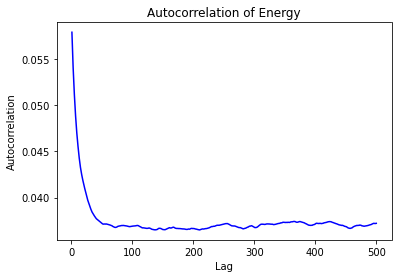

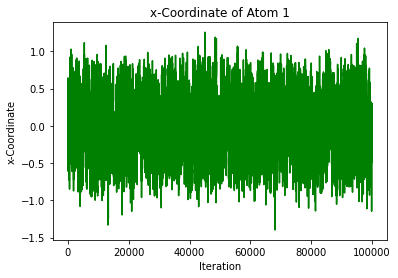

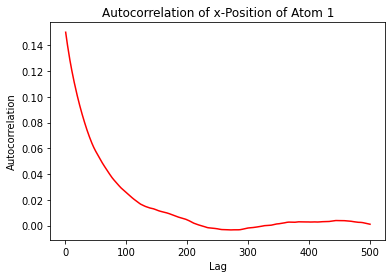

In [133]:
r_list, energy_list = metropolis_sampling(r_atoms, 0.1, 10 ** 5)
plot_autocorrelation(energy_list, 500, "Autocorrelation of Energy", "blue")
# We check the x coordinate of our first atom
x_list = [r[0][0] for r in r_list]
plt.plot(range(len(x_list)), x_list, color = "green")
plt.title("x-Coordinate of Atom 1")
plt.xlabel("Iteration")
plt.ylabel("x-Coordinate")
plt.show()
plot_autocorrelation(x_list, 500, "Autocorrelation of x-Position of Atom 1", "red")


I can estimate that the autocorrelation time of energy is $T \approx 50$ and the autocorrelation time of the x-coordinate of atom 1 is $T \approx 150$.

### (d)

Finished running simulation with kT = 0.2, # iterations = 100000
Simulation time: 7.504s
Accept ratio: 0.5016


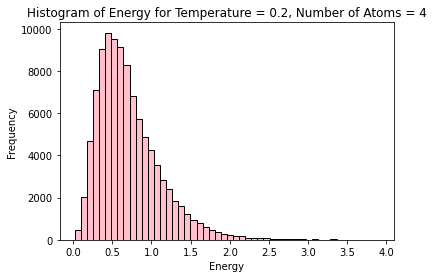

Position of atoms at the end:
[0.477, -0.61, -0.151]
[0.06, 0.572, 0.089]
[-0.739, 0.246, -0.368]
[0.202, -0.208, 0.431]
Matrix where ith row, jth column is distance between atoms i and j:
[[0.         1.27688484 1.50369275 0.75956558]
 [0.         0.         0.97663954 0.86326307]
 [0.         0.         0.         1.31510911]
 [0.         0.         0.         0.        ]]
Finished running simulation with kT = 0.04, # iterations = 100000
Simulation time: 7.869s
Accept ratio: 0.5011


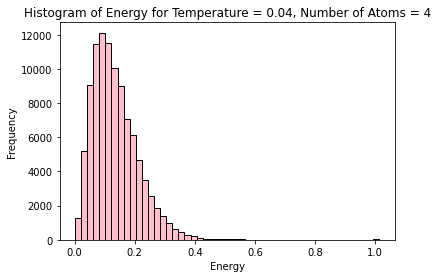

Position of atoms at the end:
[-0.355, 0.237, 0.156]
[0.304, 0.48, -0.442]
[0.342, -0.085, 0.375]
[-0.29, -0.632, -0.089]
Matrix where ith row, jth column is distance between atoms i and j:
[[0.         0.92218185 0.79864829 0.90510339]
 [0.         0.         0.99432818 1.30880651]
 [0.         0.         0.         0.95565465]
 [0.         0.         0.         0.        ]]
Finished running simulation with kT = 0.008, # iterations = 100000
Simulation time: 8.277s
Accept ratio: 0.5007


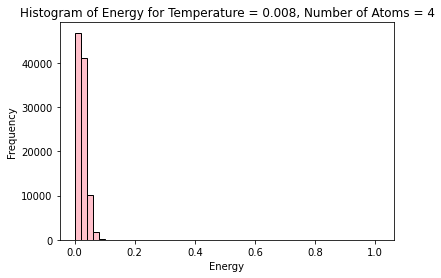

Position of atoms at the end:
[0.353, 0.037, -0.434]
[0.283, -0.074, 0.552]
[-0.362, -0.523, -0.116]
[-0.274, 0.56, -0.002]
Matrix where ith row, jth column is distance between atoms i and j:
[[0.         0.99560211 0.96223805 0.9241127 ]
 [0.         0.         1.03163643 1.01020859]
 [0.         0.         0.         1.0924332 ]
 [0.         0.         0.         0.        ]]
Finished running simulation with kT = 0.0016, # iterations = 100000
Simulation time: 7.554s
Accept ratio: 0.5003


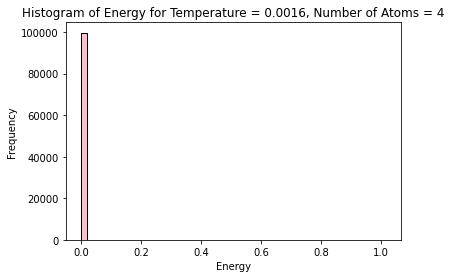

Position of atoms at the end:
[-0.254, -0.18, -0.543]
[0.362, -0.478, 0.15]
[0.346, 0.519, -0.042]
[-0.454, 0.139, 0.436]
Matrix where ith row, jth column is distance between atoms i and j:
[[0.         0.97401167 1.04920693 1.04882773]
 [0.         0.         1.01562025 1.06148791]
 [0.         0.         0.         1.00669062]
 [0.         0.         0.         0.        ]]


In [127]:
r_atoms = [
    [0, 0, 0],
    [1, .5, 0],
    [.5, 1, 1],
    [0, 2, 0.5]
]
num_atoms = len(r_atoms)

energy_list_list = []
for i in range(-1, -5, -1):
    temp = 5 ** i
    r_list, energy_list = metropolis_sampling(r_atoms, temp, 10 ** 5)
    plt.hist(energy_list, bins = 50, color = "pink", edgecolor = "black")
    plt.title(f"Histogram of Energy for Temperature = {temp}, Number of Atoms = 4")
    plt.ylabel("Frequency")
    plt.xlabel("Energy")
    plt.show()

    print("Position of atoms at the end:")
    for r in r_list[-1]:
        print(list(map(lambda x: round(x, 3), r)))

    dist_matrix = [[0] * num_atoms for _ in range(num_atoms)]
    for j in range(num_atoms):
        for k in range(j+1, num_atoms):
            diff_vec = [r_list[-1][j][idx] - r_list[-1][k][idx] for idx in range(dims)]
            dist_matrix[j][k] = norm(diff_vec)
    dist_matrix = numpy.matrix(dist_matrix)
    print("Matrix where ith row, jth column is distance between atoms i and j:")
    print(dist_matrix)


I ran my Metropolis sampling algorithm with progressively smaller temperatures in powers of 5: $kT = \frac{1}{5}, \frac{1}{5^2}, \frac{1}{5^3}, \frac{1}{5^4}$. As can be seen by my plots and printed results, it is clear that as the temperature decreases, the distribution for energy becomes narrower and starts to bunch around 0. Moreover, our atoms start to move to a structure where they are about distance 1 apart from each other. This matches what we know from (a) which is that $V(r)$ has a minimum of 0 and this is associated when 2 atoms are distance 1 apart from each other.